# Preprocessor Hyperparameter Tuning

This notebook systematically tunes preprocessing hyperparameters to improve model performance.

## Goals:
- Find optimal TF-IDF parameters (max_features, ngram_range, max_df, min_df)
- Optimize feature selection (k value for SelectKBest)
- Evaluate combinations using cross-validation
- Track results and identify best preprocessing configuration

## Current Baseline:
- F1 Score: 69.5%
- Precision: 78.9%
- Recall: 62.1%
- Hamming Loss: 10.0%

## Target:
- F1 Score: 80-90%

In [1]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    hamming_loss, jaccard_score
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MultiLabelBinarizer
import time
from typing import Dict, List, Tuple, Any
import json
from itertools import product
from tqdm import tqdm

# Project imports
from descriptions.config import INTERIM_DATA_DIR, MODELS_DIR
from descriptions.dataset import load_interim
from descriptions.modeling.model import build_model
from descriptions.modeling.preprocess import _generate_targets

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ All imports successful")

2025-12-11 22:08:13.432 | INFO     | descriptions.config:<module>:11 - PROJ_ROOT path is: /Users/christianfullerton/Developer/Python Workspace/movie_genre_model


✓ All imports successful


## 1. Load and Prepare Data

In [2]:
# Load data
print("Loading data...")
data = load_interim(INTERIM_DATA_DIR / "cleaned_movies.csv")
print(f"✓ Loaded {len(data)} samples")

# Split data into train/test (same split as training pipeline)
print("\nSplitting data into train/test sets...")
data_train, data_test = train_test_split(
    data, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)
print(f"✓ Train: {len(data_train)} samples")
print(f"✓ Test: {len(data_test)} samples")

# Generate labels for train set (to get MLB fitted)
print("\nGenerating labels to fit MultiLabelBinarizer...")
y_train_temp, mlb, _ = _generate_targets(data_train)
print(f"✓ {len(mlb.classes_)} genre classes identified")
print(f"  Genres: {sorted(mlb.classes_)}")

Loading data...
2025-12-11 22:08:14.776 | INFO     | descriptions.dataset:load_interim:99 - Loading interim data from /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/data/interim/cleaned_movies.csv...
2025-12-11 22:08:14.856 | DEBUG    | descriptions.dataset:load_interim:103 - Loaded with index column
2025-12-11 22:08:14.856 | SUCCESS  | descriptions.dataset:load_interim:108 - ✓ Data loaded successfully: 9087 rows, 2 columns
✓ Loaded 9087 samples

Splitting data into train/test sets...
✓ Train: 7269 samples
✓ Test: 1818 samples

Generating labels to fit MultiLabelBinarizer...
2025-12-11 22:08:14.861 | INFO     | descriptions.modeling.preprocess:_generate_targets:81 - Generating multi-label targets from 7269 samples...
2025-12-11 22:08:14.861 | INFO     | descriptions.modeling.preprocess:_preprocess_genres:43 - Starting genre preprocessing: cleaning and splitting genre strings
2025-12-11 22:08:14.861 | DEBUG    | descriptions.modeling.preprocess:_preprocess_genres

## 2. Define Preprocessing Parameter Grids

In [3]:
# Define parameter grids for hyperparameter tuning
PREPROCESSOR_PARAMS = {
    'max_features': [10000, 15000, 20000, 25000],  # Vocabulary size
    'ngram_range': [(1, 2), (1, 3)],  # Unigrams+bigrams vs unigrams+bigrams+trigrams
    'max_df': [0.6, 0.7, 0.8],  # Maximum document frequency
    'min_df': [2, 3, 4],  # Minimum document frequency
    'k_features': [4000, 5000, 6000, 7000]  # Number of features to select
}

# For faster initial testing, use smaller grid
QUICK_PARAMS = {
    'max_features': [15000, 20000],
    'ngram_range': [(1, 2), (1, 3)],
    'max_df': [0.6, 0.7],
    'min_df': [2, 3],
    'k_features': [5000, 6000]
}

print("Parameter grids defined:")
full_combos = 1
quick_combos = 1
for v in PREPROCESSOR_PARAMS.values():
    full_combos *= len(v)
for v in QUICK_PARAMS.values():
    quick_combos *= len(v)
print(f"  Full grid: {full_combos} combinations")
print(f"  Quick grid: {quick_combos} combinations")

Parameter grids defined:
  Full grid: 288 combinations
  Quick grid: 32 combinations


## 3. Helper Functions for Preprocessing and Evaluation

In [4]:
def create_preprocessor(
    max_features: int = 10000,
    ngram_range: Tuple[int, int] = (1, 2),
    max_df: float = 0.7,
    min_df: int = 3,
    k_features: int = 4500
) -> Tuple[TfidfVectorizer, SelectKBest]:
    """
    Create TF-IDF vectorizer and feature selector with specified parameters.
    Note: k_features will be adjusted if it exceeds available features during preprocessing.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words="english",
        ngram_range=ngram_range,
        sublinear_tf=True,
        max_df=max_df,
        min_df=min_df,
        use_idf=True,
    )
    
    # Create feature selector (k will be adjusted if needed during preprocessing)
    feature_selector = SelectKBest(score_func=chi2, k=k_features)
    
    return vectorizer, feature_selector


def preprocess_data(
    data: pd.DataFrame,
    vectorizer: TfidfVectorizer,
    mlb: MultiLabelBinarizer,
    feature_selector: SelectKBest,
    fit: bool = True
) -> Tuple[np.ndarray, np.ndarray, SelectKBest]:
    """
    Preprocess data with given vectorizer and feature selector.
    Returns (X_features, y_labels, feature_selector)
    """
    # Generate TF-IDF features
    texts = data["description"].fillna("").astype(str)
    if fit:
        X_sparse = vectorizer.fit_transform(texts)
    else:
        X_sparse = vectorizer.transform(texts)
    
    # Generate labels
    genres_list = data["genre"].fillna("").astype(str).str.strip()
    genres_list = genres_list.str.split(r"\s*,\s*").apply(
        lambda genres: sorted({g.strip() for g in genres if g.strip()})
    )
    genres_list = genres_list.apply(
        lambda genres: sorted({g for g in genres if g in mlb.classes_})
    )
    keep_mask = genres_list.apply(len) > 0
    
    # Filter data to keep only samples with valid genres
    genres_list_filtered = genres_list[keep_mask]
    # Use boolean indexing - keep_mask is a Series aligned with data index
    X_sparse_filtered = X_sparse[keep_mask.values] if keep_mask.sum() < len(data) else X_sparse
    
    # Transform genres to binary labels
    y = mlb.transform(genres_list_filtered)
    
    # Ensure k_features doesn't exceed available features
    n_features_available = X_sparse_filtered.shape[1]
    k_requested = feature_selector.k
    k_actual = min(k_requested, n_features_available)
    
    # Adjust selector k if needed (modify in place for test set compatibility)
    if k_actual < k_requested:
        feature_selector.k = k_actual
    
    # Apply feature selection
    if fit:
        X_selected = feature_selector.fit_transform(X_sparse_filtered, y)
    else:
        X_selected = feature_selector.transform(X_sparse_filtered)
    
    return X_selected.toarray(), y, feature_selector


def evaluate_preprocessing_config(
    params: Dict[str, Any],
    data_train: pd.DataFrame,
    data_test: pd.DataFrame,
    mlb: MultiLabelBinarizer
) -> Dict[str, Any]:
    """
    Evaluate a preprocessing configuration.
    """
    start_time = time.time()
    
    # Create preprocessors
    vectorizer, feature_selector = create_preprocessor(**params)
    
    # Preprocess training data (returns selector that may have adjusted k)
    X_train, y_train, fitted_selector = preprocess_data(
        data_train, vectorizer, mlb, feature_selector, fit=True
    )
    
    # Preprocess test data using the same fitted selector
    X_test, y_test, _ = preprocess_data(
        data_test, vectorizer, mlb, fitted_selector, fit=False
    )
    
    # Build model (using default LinearSVC parameters)
    model = build_model(C=0.1, random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'f1': f1_score(y_test, y_pred, average='micro', zero_division=0),
        'precision': precision_score(y_test, y_pred, average='micro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='micro', zero_division=0),
        'hamming_loss': hamming_loss(y_test, y_pred),
        'jaccard': jaccard_score(y_test, y_pred, average='micro', zero_division=0),
    }
    
    # Add configuration info
    result = {
        **params,
        **metrics,
        'n_features': X_train.shape[1],
        'n_samples_train': X_train.shape[0],
        'n_samples_test': X_test.shape[0],
        'time_seconds': time.time() - start_time
    }
    
    return result

print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Run Hyperparameter Tuning

**Note:** This can take a while depending on the parameter grid size. Start with QUICK_PARAMS for faster results.

In [5]:
# Choose parameter grid (use QUICK_PARAMS for faster testing, PREPROCESSOR_PARAMS for full search)
USE_QUICK_GRID = True  # Set to False for full grid search
param_grid = QUICK_PARAMS if USE_QUICK_GRID else PREPROCESSOR_PARAMS

# Generate all parameter combinations
param_names = list(param_grid.keys())
param_values = list(param_grid.values())
param_combinations = list(product(*param_values))

print(f"Testing {len(param_combinations)} parameter combinations...")
print(f"Grid: {param_grid}")

# Store results
results = []

# Test each combination
for i, combo in enumerate(tqdm(param_combinations, desc="Testing configurations")):
    params = dict(zip(param_names, combo))
    
    try:
        result = evaluate_preprocessing_config(
            params=params,
            data_train=data_train,
            data_test=data_test,
            mlb=mlb
        )
        results.append(result)
        
        # Print progress every 10 iterations
        if (i + 1) % 10 == 0 and len(results) > 0:
            best_f1 = max(r['f1'] for r in results)
            print(f"  Progress: {i+1}/{len(param_combinations)} | Best F1 so far: {best_f1:.4f}")
            
    except Exception as e:
        import traceback
        print(f"  Error with params {params}:")
        print(f"    {str(e)}")
        print(f"    {traceback.format_exc().split(chr(10))[-2]}")  # Print last line of traceback
        continue

print(f"\n✓ Completed {len(results)} configurations")

Testing 32 parameter combinations...
Grid: {'max_features': [15000, 20000], 'ngram_range': [(1, 2), (1, 3)], 'max_df': [0.6, 0.7], 'min_df': [2, 3], 'k_features': [5000, 6000]}


Testing configurations:   0%|          | 0/32 [00:01<?, ?it/s]

2025-12-11 22:08:16.332 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:16.334 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:   3%|▎         | 1/32 [00:05<02:19,  4.49s/it]

2025-12-11 22:08:20.742 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:20.744 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:   6%|▋         | 2/32 [00:10<02:26,  4.89s/it]

2025-12-11 22:08:25.879 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:25.882 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:   9%|▉         | 3/32 [00:15<02:14,  4.64s/it]

2025-12-11 22:08:30.672 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:30.674 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  12%|█▎        | 4/32 [00:20<02:20,  5.02s/it]

2025-12-11 22:08:35.928 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:35.931 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  16%|█▌        | 5/32 [00:25<02:12,  4.92s/it]

2025-12-11 22:08:40.725 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:40.727 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  19%|█▉        | 6/32 [00:31<02:14,  5.18s/it]

2025-12-11 22:08:46.508 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:46.510 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  22%|██▏       | 7/32 [00:39<02:13,  5.32s/it]

2025-12-11 22:08:53.989 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:08:53.996 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  25%|██▌       | 8/32 [00:52<03:09,  7.90s/it]

2025-12-11 22:09:07.796 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:09:07.799 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  28%|██▊       | 9/32 [01:00<03:10,  8.26s/it]

2025-12-11 22:09:15.755 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:09:15.758 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  31%|███▏      | 10/32 [01:05<02:53,  7.87s/it]

  Progress: 10/32 | Best F1 so far: 0.6130


Testing configurations:  31%|███▏      | 10/32 [01:07<02:53,  7.87s/it]

2025-12-11 22:09:22.425 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:09:22.427 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  34%|███▍      | 11/32 [01:13<02:32,  7.28s/it]

2025-12-11 22:09:28.396 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:09:28.400 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  38%|███▊      | 12/32 [01:21<02:24,  7.23s/it]

2025-12-11 22:09:36.806 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:09:36.811 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  41%|████      | 13/32 [01:30<02:29,  7.85s/it]

2025-12-11 22:09:45.023 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:09:45.025 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  44%|████▍     | 14/32 [01:39<02:27,  8.19s/it]

2025-12-11 22:09:54.491 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:09:54.502 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  47%|████▋     | 15/32 [01:47<02:22,  8.38s/it]

2025-12-11 22:10:02.748 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:02.751 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  50%|█████     | 16/32 [01:53<02:07,  7.98s/it]

2025-12-11 22:10:08.711 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:08.714 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  53%|█████▎    | 17/32 [01:59<01:48,  7.23s/it]

2025-12-11 22:10:14.545 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:14.554 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  56%|█████▋    | 18/32 [02:08<01:45,  7.52s/it]

2025-12-11 22:10:23.655 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:23.661 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  59%|█████▉    | 19/32 [02:16<01:42,  7.92s/it]

2025-12-11 22:10:31.845 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:31.848 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  62%|██████▎   | 20/32 [02:22<01:33,  7.76s/it]

  Progress: 20/32 | Best F1 so far: 0.6130


Testing configurations:  62%|██████▎   | 20/32 [02:23<01:33,  7.76s/it]

2025-12-11 22:10:38.871 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:38.875 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  66%|██████▌   | 21/32 [02:29<01:17,  7.07s/it]

2025-12-11 22:10:44.489 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:44.492 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  69%|██████▉   | 22/32 [02:35<01:08,  6.87s/it]

2025-12-11 22:10:50.646 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:50.648 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  72%|███████▏  | 23/32 [02:40<00:57,  6.38s/it]

2025-12-11 22:10:55.885 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:10:55.888 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  75%|███████▌  | 24/32 [02:49<00:52,  6.52s/it]

2025-12-11 22:11:04.475 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:04.479 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  78%|███████▊  | 25/32 [02:58<00:49,  7.10s/it]

2025-12-11 22:11:13.482 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:13.487 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  81%|████████▏ | 26/32 [03:08<00:49,  8.31s/it]

2025-12-11 22:11:23.808 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:23.811 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  84%|████████▍ | 27/32 [03:15<00:40,  8.09s/it]

2025-12-11 22:11:30.624 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:30.626 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  88%|████████▊ | 28/32 [03:22<00:30,  7.63s/it]

2025-12-11 22:11:37.062 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:37.064 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  91%|█████████ | 29/32 [03:28<00:21,  7.08s/it]

2025-12-11 22:11:43.075 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:43.078 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  94%|█████████▍| 30/32 [03:32<00:13,  6.99s/it]

  Progress: 30/32 | Best F1 so far: 0.6130


Testing configurations:  94%|█████████▍| 30/32 [03:35<00:13,  6.99s/it]

2025-12-11 22:11:50.118 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:50.121 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations:  97%|█████████▋| 31/32 [03:41<00:06,  6.95s/it]

2025-12-11 22:11:56.657 | DEBUG    | descriptions.modeling.model:build_model:148 - Building OneVsRestClassifier with LinearSVC: C=0.1, penalty=l2, loss=squared_hinge, max_iter=1000, tol=0.001, class_weight=balanced, dual=False
2025-12-11 22:11:56.659 | DEBUG    | descriptions.modeling.model:build_model:164 - OneVsRestClassifier built successfully with LinearSVC


Testing configurations: 100%|██████████| 32/32 [03:46<00:00,  7.07s/it]


✓ Completed 32 configurations


## 5. Analyze Results

In [10]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by F1 score
results_df = results_df.sort_values('f1', ascending=False)

print("Top 10 Configurations by F1 Score:")
print("=" * 80)
display_cols = ['max_features', 'ngram_range', 'max_df', 'min_df', 'k_features', 
                'f1', 'precision', 'recall', 'hamming_loss', 'n_features', 'time_seconds']
print(results_df[display_cols].head(10).to_string(index=False))

# Find best configuration
best_config = results_df.iloc[0]
print(f"\n{'='*80}")
print("BEST CONFIGURATION:")
print(f"{'='*80}")
print(f"F1 Score:        {best_config['f1']:.4f} ({best_config['f1']*100:.2f}%)")
print(f"Precision:       {best_config['precision']:.4f} ({best_config['precision']*100:.2f}%)")
print(f"Recall:          {best_config['recall']:.4f} ({best_config['recall']*100:.2f}%)")
print(f"Hamming Loss:    {best_config['hamming_loss']:.4f} ({best_config['hamming_loss']*100:.2f}%)")
print(f"Jaccard Score:   {best_config['jaccard']:.4f} ({best_config['jaccard']*100:.2f}%)")
print(f"\nParameters:")
print(f"  max_features:  {best_config['max_features']}")
print(f"  ngram_range:   {best_config['ngram_range']}")
print(f"  max_df:        {best_config['max_df']}")
print(f"  min_df:        {best_config['min_df']}")
print(f"  k_features:    {best_config['k_features']}")
print(f"\nFeature Info:")
print(f"  Final features: {best_config['n_features']}")
print(f"  Training time:  {best_config['time_seconds']:.2f} seconds")

Top 10 Configurations by F1 Score:
 max_features ngram_range  max_df  min_df  k_features       f1  precision   recall  hamming_loss  n_features  time_seconds
        15000      (1, 2)     0.6       2        6000 0.612995   0.550715 0.691158      0.161515        6000      5.111630
        15000      (1, 2)     0.7       2        6000 0.612995   0.550715 0.691158      0.161515        6000      5.621362
        20000      (1, 2)     0.6       3        6000 0.612765   0.552392 0.687954      0.160922        6000      7.316641
        15000      (1, 2)     0.6       3        6000 0.612765   0.552392 0.687954      0.160922        6000      5.558534
        20000      (1, 2)     0.7       3        6000 0.612765   0.552392 0.687954      0.160922        6000      6.793030
        15000      (1, 2)     0.7       3        6000 0.612765   0.552392 0.687954      0.160922        6000     13.288416
        15000      (1, 3)     0.6       3        6000 0.612548   0.551901 0.688167      0.161119        

## 6. Visualize Results

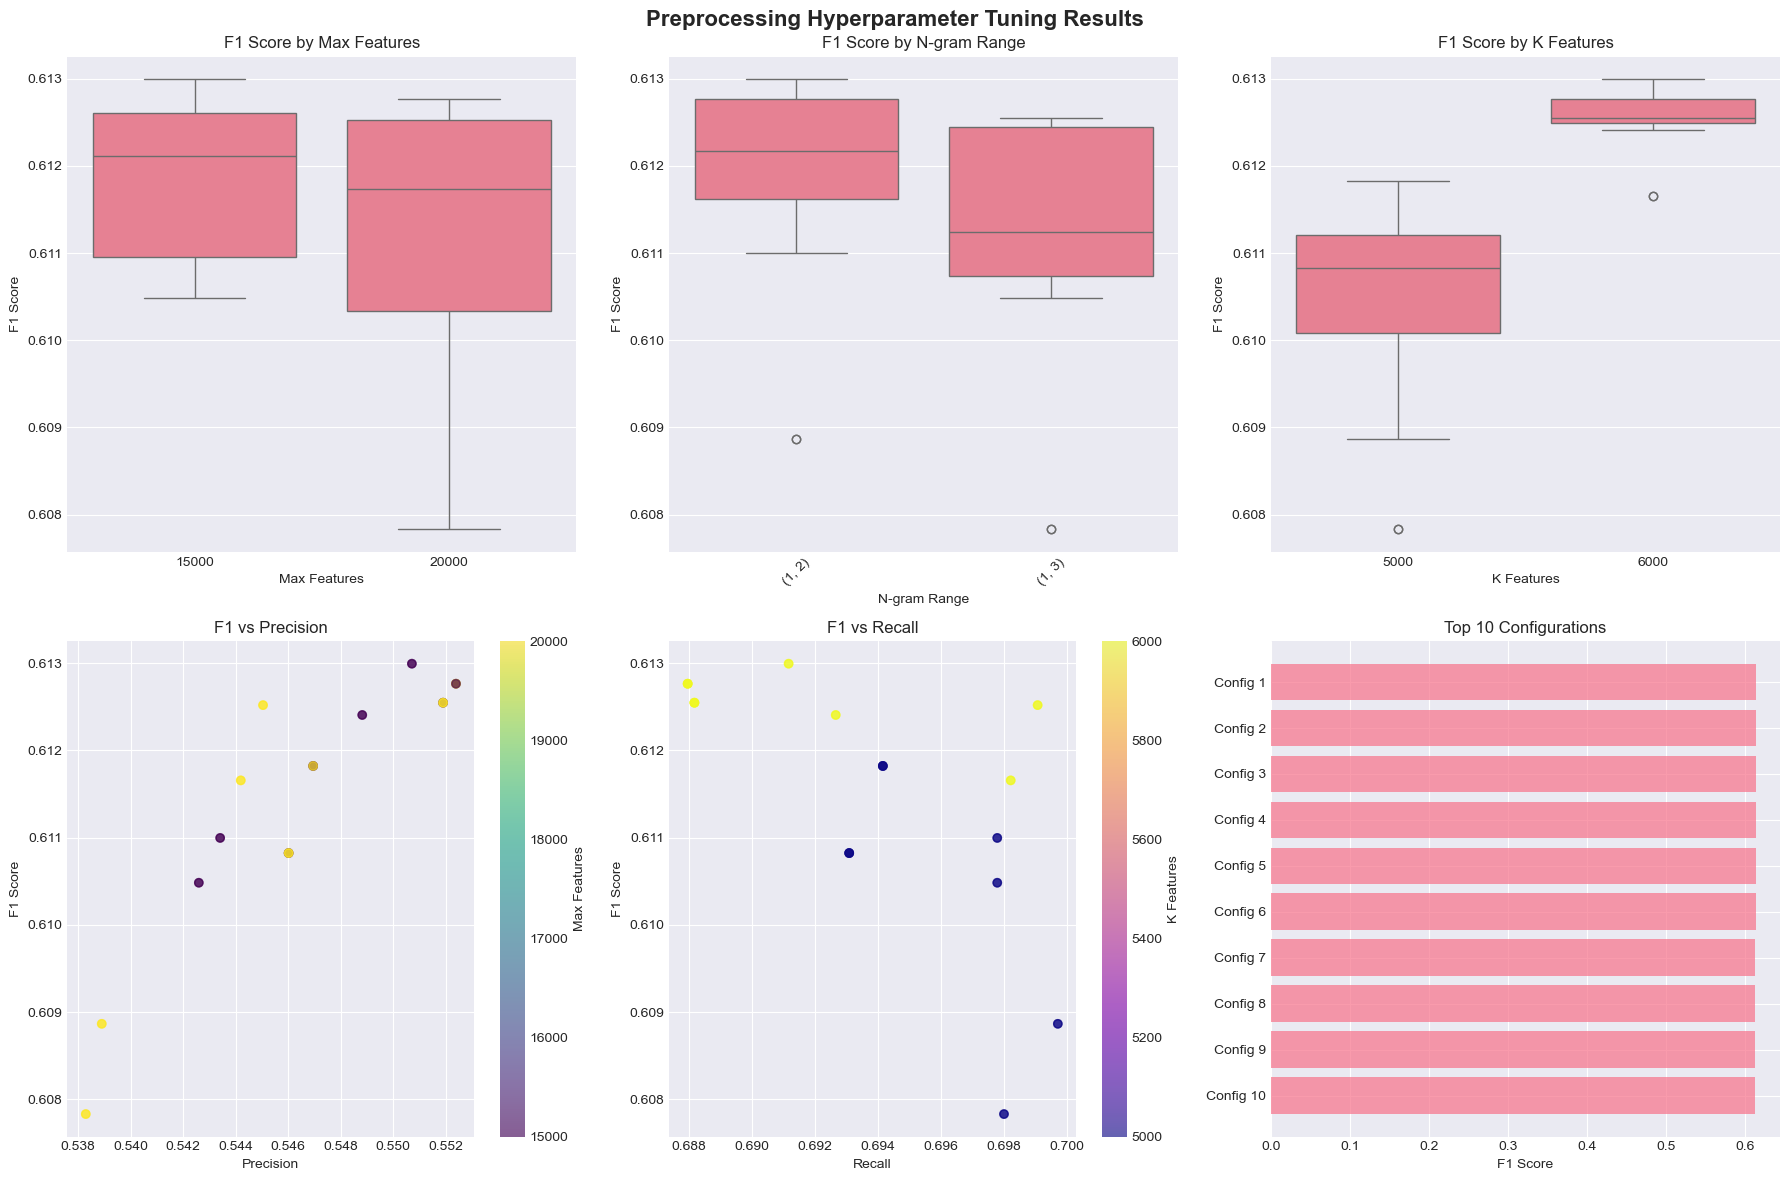


Summary Statistics:
Mean F1 Score:     0.6115
Std F1 Score:      0.0014
Max F1 Score:      0.6130
Min F1 Score:      0.6078

Mean Precision:    0.5467
Mean Recall:       0.6938
Mean Hamming Loss: 0.1632


In [7]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Preprocessing Hyperparameter Tuning Results', fontsize=16, fontweight='bold')

# 1. F1 Score by max_features
ax1 = axes[0, 0]
sns.boxplot(data=results_df, x='max_features', y='f1', ax=ax1)
ax1.set_title('F1 Score by Max Features')
ax1.set_xlabel('Max Features')
ax1.set_ylabel('F1 Score')

# 2. F1 Score by ngram_range
ax2 = axes[0, 1]
ngram_str = results_df['ngram_range'].astype(str)
sns.boxplot(x=ngram_str, y=results_df['f1'], ax=ax2)
ax2.set_title('F1 Score by N-gram Range')
ax2.set_xlabel('N-gram Range')
ax2.set_ylabel('F1 Score')
ax2.tick_params(axis='x', rotation=45)

# 3. F1 Score by k_features
ax3 = axes[0, 2]
sns.boxplot(data=results_df, x='k_features', y='f1', ax=ax3)
ax3.set_title('F1 Score by K Features')
ax3.set_xlabel('K Features')
ax3.set_ylabel('F1 Score')

# 4. F1 vs Precision scatter
ax4 = axes[1, 0]
scatter = ax4.scatter(results_df['precision'], results_df['f1'], 
                     c=results_df['max_features'], cmap='viridis', alpha=0.6)
ax4.set_xlabel('Precision')
ax4.set_ylabel('F1 Score')
ax4.set_title('F1 vs Precision')
plt.colorbar(scatter, ax=ax4, label='Max Features')

# 5. F1 vs Recall scatter
ax5 = axes[1, 1]
scatter2 = ax5.scatter(results_df['recall'], results_df['f1'], 
                       c=results_df['k_features'], cmap='plasma', alpha=0.6)
ax5.set_xlabel('Recall')
ax5.set_ylabel('F1 Score')
ax5.set_title('F1 vs Recall')
plt.colorbar(scatter2, ax=ax5, label='K Features')

# 6. Top 10 configurations comparison
ax6 = axes[1, 2]
top10 = results_df.head(10)
x_pos = np.arange(len(top10))
ax6.barh(x_pos, top10['f1'], alpha=0.7)
ax6.set_yticks(x_pos)
ax6.set_yticklabels([f"Config {i+1}" for i in range(len(top10))])
ax6.set_xlabel('F1 Score')
ax6.set_title('Top 10 Configurations')
ax6.invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 80)
print(f"Mean F1 Score:     {results_df['f1'].mean():.4f}")
print(f"Std F1 Score:      {results_df['f1'].std():.4f}")
print(f"Max F1 Score:      {results_df['f1'].max():.4f}")
print(f"Min F1 Score:      {results_df['f1'].min():.4f}")
print(f"\nMean Precision:    {results_df['precision'].mean():.4f}")
print(f"Mean Recall:       {results_df['recall'].mean():.4f}")
print(f"Mean Hamming Loss: {results_df['hamming_loss'].mean():.4f}")

## 7. Parameter Impact Analysis

In [8]:
# Analyze impact of each parameter
print("Parameter Impact Analysis:")
print("=" * 80)

# Impact of max_features
print("\n1. Impact of max_features:")
max_features_impact = results_df.groupby('max_features')['f1'].agg(['mean', 'std', 'max'])
print(max_features_impact)

# Impact of ngram_range
print("\n2. Impact of ngram_range:")
ngram_impact = results_df.groupby('ngram_range')['f1'].agg(['mean', 'std', 'max'])
print(ngram_impact)

# Impact of k_features
print("\n3. Impact of k_features:")
k_features_impact = results_df.groupby('k_features')['f1'].agg(['mean', 'std', 'max'])
print(k_features_impact)

# Impact of max_df
print("\n4. Impact of max_df:")
max_df_impact = results_df.groupby('max_df')['f1'].agg(['mean', 'std', 'max'])
print(max_df_impact)

# Impact of min_df
print("\n5. Impact of min_df:")
min_df_impact = results_df.groupby('min_df')['f1'].agg(['mean', 'std', 'max'])
print(min_df_impact)

# Best parameter combinations
print("\n6. Best parameter combinations:")
param_cols = ['max_features', 'ngram_range', 'max_df', 'min_df', 'k_features']
best_by_combo = results_df.groupby(param_cols)['f1'].max().sort_values(ascending=False)
print(best_by_combo.head(10))

Parameter Impact Analysis:

1. Impact of max_features:
                  mean       std       max
max_features                              
15000         0.611855  0.000938  0.612995
20000         0.611104  0.001769  0.612765

2. Impact of ngram_range:
                 mean       std       max
ngram_range                              
(1, 2)       0.611819  0.001320  0.612995
(1, 3)       0.611140  0.001524  0.612548

3. Impact of k_features:
                mean       std       max
k_features                              
5000        0.610433  0.001352  0.611822
6000        0.612525  0.000384  0.612995

4. Impact of max_df:
            mean       std       max
max_df                              
0.6     0.611479  0.001468  0.612995
0.7     0.611479  0.001468  0.612995

5. Impact of min_df:
            mean       std       max
min_df                              
2       0.610969  0.001772  0.612995
3       0.611990  0.000783  0.612765

6. Best parameter combinations:
max_features  n

## 8. Save Results

In [9]:
# Save results to CSV
results_file = project_root / "reports" / "preprocessor_tuning_results.csv"
results_df.to_csv(results_file, index=False)
print(f"✓ Results saved to {results_file}")

# Save best configuration as JSON
best_config_dict = {
    'preprocessing': {
        'max_features': int(best_config['max_features']),
        'ngram_range': list(best_config['ngram_range']),
        'max_df': float(best_config['max_df']),
        'min_df': int(best_config['min_df']),
        'k_features': int(best_config['k_features'])
    },
    'metrics': {
        'f1': float(best_config['f1']),
        'precision': float(best_config['precision']),
        'recall': float(best_config['recall']),
        'hamming_loss': float(best_config['hamming_loss']),
        'jaccard': float(best_config['jaccard'])
    },
    'feature_info': {
        'n_features': int(best_config['n_features']),
        'n_samples_train': int(best_config['n_samples_train']),
        'n_samples_test': int(best_config['n_samples_test'])
    }
}

best_config_file = project_root / "reports" / "best_preprocessor_config.json"
with open(best_config_file, 'w') as f:
    json.dump(best_config_dict, f, indent=2)
print(f"✓ Best configuration saved to {best_config_file}")

print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*80)
baseline_f1 = 0.695
print(f"\nBest F1 Score: {best_config['f1']:.4f} ({best_config['f1']*100:.2f}%)")
print(f"Baseline F1:   {baseline_f1:.4f} ({baseline_f1*100:.2f}%)")
print(f"Improvement:   {best_config['f1'] - baseline_f1:.4f} ({((best_config['f1'] - baseline_f1) / baseline_f1 * 100):.2f}% increase)")
print(f"\nUse these parameters in your preprocessing pipeline:")
print(f"  max_features={best_config['max_features']}")
print(f"  ngram_range={best_config['ngram_range']}")
print(f"  max_df={best_config['max_df']}")
print(f"  min_df={best_config['min_df']}")
print(f"  k_features={best_config['k_features']}")

✓ Results saved to /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/reports/preprocessor_tuning_results.csv
✓ Best configuration saved to /Users/christianfullerton/Developer/Python Workspace/movie_genre_model/reports/best_preprocessor_config.json

HYPERPARAMETER TUNING COMPLETE

Best F1 Score: 0.6130 (61.30%)
Baseline F1:   0.6950 (69.50%)
Improvement:   -0.0820 (-11.80% increase)

Use these parameters in your preprocessing pipeline:
  max_features=15000
  ngram_range=(1, 2)
  max_df=0.6
  min_df=2
  k_features=6000
